In [1]:
import os
import numpy as np
import torch
import cv2
import json
from config_cropping import cfg
from CACNet import CACNet
from PIL import Image
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
weight_file = "./pretrained_models/best-FLMS_iou.pth"
model = CACNet(loadweights=False)
model.load_state_dict(torch.load(weight_file,map_location=device))
model = model.to(device).eval()

d:\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
d:\anaconda3\envs\venv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
IMAGE_NET_MEAN = [0.485, 0.456, 0.406]
IMAGE_NET_STD = [0.229, 0.224, 0.225]

def parse_annotation(index):
    data_file = os.path.join(cfg.FCDB_dir, 'cropping_testing_set.json')
    origin_data = json.loads(open(data_file, 'r').read())
    image_data = origin_data[index]
    image = os.path.split(image_data['url'])[-1]
    x,y,w,h = image_data['crop']
    gt_crop= [x,y,x+w,y+h]
    gt_crop = np.array(gt_crop).reshape(-1,4).astype(np.float32)
    return image,gt_crop
    
def process_image(image_file):
    image = Image.open(image_file).convert('RGB')
    im_width, im_height = image.size
    h = cfg.image_size[1]
    w = cfg.image_size[0]
    resized_image = image.resize((w, h), Image.LANCZOS)
    image_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_NET_MEAN, std=IMAGE_NET_STD)])
    im = image_transformer(resized_image)
    return im, im_width, im_height, image_file

def predict(image,model = model):
    logits,kcm,crop = model(image, only_classify=False)
    return logits,kcm,crop

def crop_image(image):
    im, im_width, im_height, image_file = process_image(image)
    if im.dim()<4:
        im = im.unsqueeze(0)
    im = im.to(device)
    logits,kcm,crop = predict(im)
    crop[:,0::2] = crop[:,0::2] / im.shape[-1] * im_width
    crop[:,1::2] = crop[:,1::2] / im.shape[-2] * im_height
    pred_crop = crop.detach().cpu()
    pred_crop[:,0::2] = torch.clip(pred_crop[:,0::2], min=0, max=im_width)
    pred_crop[:,1::2] = torch.clip(pred_crop[:,1::2], min=0, max=im_height)
    pred_crop = pred_crop[0].numpy().tolist()
    x1,y1,x2,y2 = [int(x) for x in pred_crop]
    source_img = cv2.imread(image_file)
    source_img = cv2.rectangle(source_img , (x1,y1), (x2,y2), (255,0,0), 2) 
    return source_img

(768, 1024, 3)


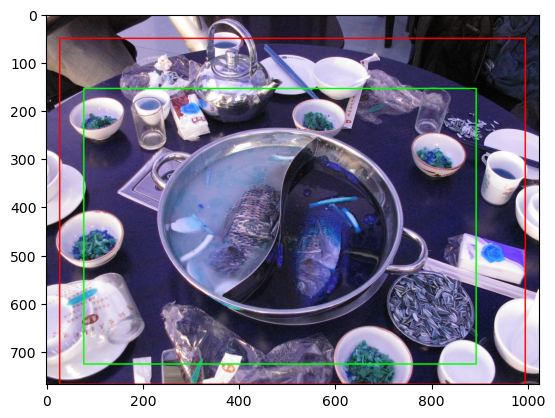

In [5]:
image_file,gt_crop = parse_annotation(3)
x1,y1,x2,y2 = [int(x) for x in gt_crop[0]]
image_file = os.path.join(cfg.FCDB_dir,f'data/{image_file}')
image_file = crop_image(image_file)
image_file = cv2.rectangle(image_file , (x1,y1), (x2,y2), (0,255,0), 2) 
import matplotlib.pyplot as plt 
plt.imshow(image_file)
print(image_file.shape)

d:\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


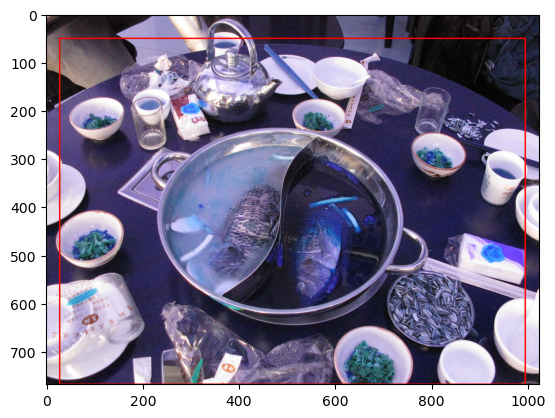

In [6]:
from crop import Cropper
image_file,gt_crop = parse_annotation(3)
image_file = os.path.join(cfg.FCDB_dir,f'data/{image_file}')
crop_model = Cropper()
img,x1,y1,x2,y2 = crop_model.crop_image(image_file)
import matplotlib.pyplot as plt 
plt.imshow(img)

In [34]:
img

array([[[255, 242, 236],
        [255, 240, 234],
        [255, 242, 237],
        ...,
        [ 34,  32,  52],
        [ 43,  41,  61],
        [ 45,  42,  64]],

       [[255, 241, 228],
        [255, 241, 229],
        [253, 239, 233],
        ...,
        [ 35,  33,  55],
        [ 39,  37,  59],
        [ 40,  37,  62]],

       [[249, 236, 222],
        [250, 238, 226],
        [245, 233, 227],
        ...,
        [ 32,  35,  56],
        [ 33,  36,  57],
        [ 33,  35,  59]],

       ...,

       [[ 39,  38,  48],
        [ 38,  37,  47],
        [ 28,  24,  35],
        ...,
        [ 85,  80,  89],
        [ 73,  66,  73],
        [ 56,  49,  56]],

       [[ 41,  40,  50],
        [ 40,  39,  49],
        [ 29,  25,  36],
        ...,
        [ 87,  83,  95],
        [ 85,  79,  90],
        [ 77,  71,  82]],

       [[ 44,  43,  53],
        [ 39,  38,  48],
        [ 36,  35,  45],
        ...,
        [ 85,  80,  95],
        [ 86,  82,  94],
        [ 84,  80,  92]]

In [41]:
import io
a=io.BytesIO()
np.save(a, img)
# print(a)
# b = np.load(io.BytesIO(a.getvalue()))
Image.open(a).convert('RGB')

print(a)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000001E091F9AAC0>